In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
import math
import datetime
import tensorflow as tf
from tensorflow import keras
from google.colab import files   #Comment this line if you are not using google colab

#plt.rc('xtick',labelsize=30)
#plt.rc('ytick',labelsize=30)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
df = pd.read_csv('/content/drive/My Drive/Weather Prediction and Forecasting/inter-999-interpolate_final.csv', parse_dates=['obstime'], index_col=['obstime'])  # Reading the csv file and making the obstime column 
                                                                                                                             # as index of dataframe after converting it to datetime
df = df.iloc[:, 0:1]    # We are interested in temperature forecasting
df   

,tempr
obstime,
2016-02-06 00:00:00,-13.58
2016-02-06 01:00:00,-13.95
2016-02-06 02:00:00,-13.96
2016-02-06 03:00:00,-14.16
2016-02-06 04:00:00,-14.49
...,...
2019-06-19 19:00:00,-26.06
2019-06-19 20:00:00,-26.10
2019-06-19 21:00:00,-26.75


In [ ]:
"""
Since we have hourly tempertaures and we are interested in forecasting daily temperatures, 
we will manually calculate the daily mean temperature

"""

from pandas.tseries.offsets import DateOffset
add_dates = [datetime.datetime(2016, 6, 2) + DateOffset(days=x) for x in range(0,1112+1) ]    # Our dataset contains 1113 days [2 June 2016 - 19 June 2019]
temp_avg = pd.Series(range(1113), index = range(1113))
start = 0
end = 0
for i in range(1113):
    end = end + 24
    ser = df.iloc[start:end, 0]
    temp_avg.update(pd.Series([round((ser.sum())/24.0, 2)], index = [i]))        # Calcuating the daily mean temperature and also rounding off to 2 decimal places
    start = end

df = pd.DataFrame(temp_avg.tolist(),index=add_dates[0:], columns=['tempr'])       # Daily average temperatures
df

,tempr
2016-06-02,-15.25
2016-06-03,-19.66
2016-06-04,-19.92
2016-06-05,-17.99
2016-06-06,-16.07
...,...
2019-06-15,-21.77
2019-06-16,-20.06
2019-06-17,-17.40
2019-06-18,-17.43


In [ ]:
time_steps = 30

train_size = 943        # Training duration - 2 June 2016 - 31 Dec 2018 (80 % data)
test_size = len(df) - train_size           # Test duration - 1 Jan 2019- 19 June 2019
train, test = df.iloc[0:train_size], df.iloc[train_size - time_steps : len(df)]

In [ ]:
train  
#test      #Uncomment and run to see the train and test dataframes

,tempr
2016-06-02,-15.25
2016-06-03,-19.66
2016-06-04,-19.92
2016-06-05,-17.99
2016-06-06,-16.07
...,...
2018-12-27,1.19
2018-12-28,0.68
2018-12-29,0.45
2018-12-30,0.54


In [ ]:
def create_dataset(X, y, time_steps):      
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [ ]:
X_train, y_train = create_dataset(train, train.tempr, time_steps)
X_test, y_test = create_dataset(test, test.tempr, time_steps)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(913, 30, 1) (913,)
(170, 30, 1) (170,)


In [ ]:
#Uncomment to see
#print(X_train)   
#print(y_train)

In [ ]:
#Uncomment to see
#print(X_test)   
#print(y_test)

In [ ]:
"""
Creating the model using keras API of tensorflow
"""

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
model = Sequential()
model.add(Conv1D(filters = 64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

model.compile(optimizer=keras.optimizers.Adam(0.001), loss='mean_squared_error')
model.summary()


Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 28, 64)            256       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 14, 64)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 896)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                28704     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 28,993
Trainable params: 28,993
Non-trainable params: 0
_________________________________________________________________


In [ ]:
"""
Train the model using appropriate batch size and epochs

"""
history = model.fit(
    X_train, y_train, 
    epochs=100, 
    batch_size=32, 
    validation_split=0.1, 
    verbose=1, 
    shuffle=False
)

Train on 821 samples, validate on 92 samples
Epoch 1/100
821/821 [==============================] - 6s 7ms/step - loss: 45.7825 - val_loss: 11.7694
Epoch 2/100
821/821 [==============================] - 0s 113us/step - loss: 29.3597 - val_loss: 14.3805
Epoch 3/100
821/821 [==============================] - 0s 117us/step - loss: 30.0562 - val_loss: 16.7742
Epoch 4/100
821/821 [==============================] - 0s 109us/step - loss: 31.5540 - val_loss: 21.5754
Epoch 5/100
821/821 [==============================] - 0s 108us/step - loss: 27.0844 - val_loss: 13.2146
Epoch 6/100
821/821 [==============================] - 0s 117us/step - loss: 21.7478 - val_loss: 13.6605
Epoch 7/100
821/821 [==============================] - 0s 118us/step - loss: 20.3973 - val_loss: 8.9553
Epoch 8/100
821/821 [==============================] - 0s 130us/step - loss: 16.6996 - val_loss: 9.7722
Epoch 9/100
821/821 [==============================] - 0s 123us/step - loss: 15.8257 - val_loss: 8.3186
Epoch 10/100
82

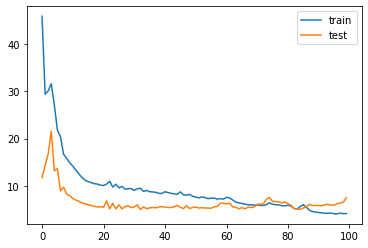

In [ ]:
"""
Let's see how our model is learning after every epoch

"""
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

In [ ]:
y_pred = model.predict(X_test)   # Making predictions on our testing data
y_pred = np.round(y_pred, decimals=2)  #Round off to 2 decimals

In [ ]:
df_test_pred = test[time_steps:]
df_test_pred['Prediction'] = y_pred
df_test_pred               # Dataframe containing the actual and predicted temperatures

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,tempr,Prediction
2019-01-01,0.30,0.570000
2019-01-02,-0.60,1.510000
2019-01-03,-0.74,0.750000
2019-01-04,-0.28,0.830000
2019-01-05,0.36,1.030000
...,...,...
2019-06-15,-21.77,-18.910000
2019-06-16,-20.06,-24.020000
2019-06-17,-17.40,-20.080000
2019-06-18,-17.43,-17.990000


In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
testScore_mse = mean_squared_error(df_test_pred['tempr'], df_test_pred['Prediction'])  #  mean square error on test data ( ACTUAL AND PREDICTED )
testScore_rmse = math.sqrt(mean_squared_error(df_test_pred['tempr'], df_test_pred['Prediction']))   # Root mean square error on test data ( ACTUAL AND PREDICTED )
testScore_mae = mean_absolute_error(df_test_pred['tempr'], df_test_pred['Prediction'])   # mean absolute error on test data ( ACTUAL AND PREDICTED )
print("Mean Squared Error = "+str(testScore_mse))
print("Root Mean Squared Error = "+str(testScore_rmse))
print("Mean Absolute Error = "+str(testScore_mae))

Mean Squared Error = 11.836032088140543
Root Mean Squared Error = 3.4403534830218456
Mean Absolute Error = 2.6290588574348126


In [ ]:
import matplotlib.style as style
style.use('seaborn-poster') #sets the size of the charts
style.use('ggplot')
fig, ax = plt.subplots(figsize=(50,20))
ax.set_facecolor(	'#FFFFE0')
plt.plot(train.index, train['tempr'], label="Training data", color = 'blue')
plt.plot(df_test_pred.index, df_test_pred['tempr'], marker='.', color = '#013220', label="Actual temperatures")
plt.plot(df_test_pred.index, df_test_pred['Prediction'] , 'r', label="Predicted Temperatures")
plt.legend(loc='best', fontsize='xx-large')
plt.xlabel('Timestep', size = 30)
plt.ylabel('Temperature (deg celsius)', size = 28 )
plt.title("Digital Current Weather Information System (DCWIS)\n Parameter - Temperature\n Duration of Training = 2016-06-02 :: 2018-12-31 (80% data)\n Predicted Duration = 2019-01-01 :: 2019-06-19 (20% data)", size = 40)
plt.xticks(fontsize=27)
plt.yticks(fontsize=27)
plt.legend(fontsize = 23) 
ax.set_xlim([df.index.min(), df.index.max()])

plt.grid(color='black', linestyle='-.', linewidth=0.9)
plt.savefig('cnn.png',dpi=250)
#files.download("cnn.png")   #Uncomment to download the file if you are using google colab